# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 363716116939215838
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.658s 


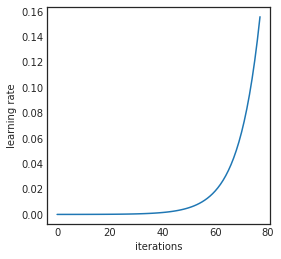

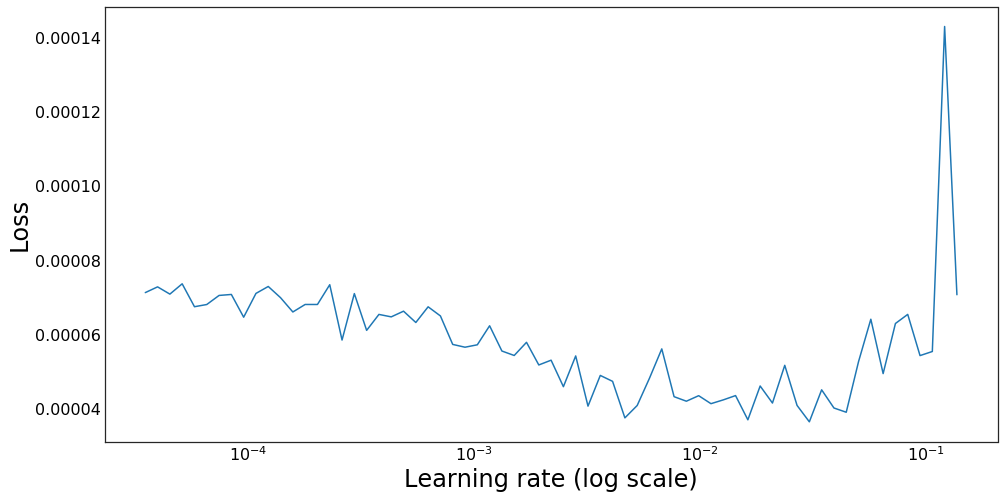

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 1e-3

In [8]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [9]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if self.sgdReplacement:
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

SWA beginning
model is 0 epochs old
1 swa loss 3.8818116216639346e-05, default loss 3.8818116216639346e-05
1 New best found: 3.8818116216639346e-05
model is 1 epochs old
2 swa loss 3.74086497803131e-05, default loss 3.690133188561882e-05
2 New best found: 3.690133188561882e-05
model is 2 epochs old
3 swa loss 3.648068283910239e-05, default loss 3.633173725600578e-05
3 New best found: 3.633173725600578e-05
model is 3 epochs old
4 swa loss 3.599977126930092e-05, default loss 3.518808561212798e-05
4 New best found: 3.518808561212798e-05
model is 4 epochs old
5 swa loss 3.551659022999022e-05, default loss 3.545738722178298e-05
model is 5 epochs old
6 swa loss 3.522406375523041e-05, default loss 3.453097020943199e-05
6 New best found: 3.453097020943199e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.497555042951202e-05, default loss 3.44445128926615e-05
7 New best found: 3.44445128926615e-05

model is 13 epochs old
new model is 4 epochs old
53 swa loss 3.211185734941545e-05, default loss 3.245248625242778e-05
53 New best found: 3.211185734941545e-05
model is 14 epochs old
new model is 5 epochs old
54 swa loss 3.208832034527698e-05, default loss 3.222951861910085e-05
54 New best found: 3.208832034527698e-05
model is 15 epochs old
new model is 6 epochs old
55 swa loss 3.2090965829373726e-05, default loss 3.280479939038223e-05
model is 16 epochs old
new model is 7 epochs old
56 swa loss 3.208403357195194e-05, default loss 3.237374847035981e-05
56 New best found: 3.208403357195194e-05
model is 17 epochs old
new model is 8 epochs old
57 swa loss 3.207677235432708e-05, default loss 3.2537410692110884e-05
57 New best found: 3.207677235432708e-05
model is 18 epochs old
new model is 9 epochs old
58 swa loss 3.2072175470268226e-05, default loss 3.267077874973841e-05
58 New best found: 3.2072175470268226e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model,

105 swa loss 3.174819430711629e-05, default loss 3.222575674775462e-05
105 New best found: 3.174819430711629e-05
model is 28 epochs old
new model is 9 epochs old
106 swa loss 3.17441156444652e-05, default loss 3.217211467596763e-05
106 New best found: 3.17441156444652e-05
model is 29 epochs old
new model is 10 epochs old
107 swa loss 3.1743148417187426e-05, default loss 3.232484619562504e-05
107 New best found: 3.1743148417187426e-05
model is 30 epochs old
new model is 11 epochs old
108 swa loss 3.174217627801131e-05, default loss 3.2265906586090254e-05
108 New best found: 3.174217627801131e-05
model is 31 epochs old
new model is 12 epochs old
109 swa loss 3.173901108647527e-05, default loss 3.205486679718398e-05
109 New best found: 3.173901108647527e-05
model is 32 epochs old
new model is 13 epochs old
110 swa loss 3.173255676026602e-05, default loss 3.2022608939535954e-05
110 New best found: 3.173255676026602e-05
model is 33 epochs old
new model is 14 epochs old
111 swa loss 3.172788

model is 45 epochs old
new model is 11 epochs old
157 swa loss 3.1563187634361555e-05, default loss 3.216135657852882e-05
157 New best found: 3.1563187634361555e-05
model is 46 epochs old
new model is 12 epochs old
158 swa loss 3.1559119514398345e-05, default loss 3.1746651585896794e-05
158 New best found: 3.1559119514398345e-05
model is 47 epochs old
new model is 13 epochs old
159 swa loss 3.1554577318105054e-05, default loss 3.181018480091744e-05
159 New best found: 3.1554577318105054e-05
model is 48 epochs old
new model is 14 epochs old
160 swa loss 3.155420676716593e-05, default loss 3.2034197518167605e-05
160 New best found: 3.155420676716593e-05
model is 49 epochs old
new model is 15 epochs old
161 swa loss 3.1552139355776924e-05, default loss 3.193880936126925e-05
161 New best found: 3.1552139355776924e-05
model is 50 epochs old
new model is 16 epochs old
162 swa loss 3.1549605168891736e-05, default loss 3.1905012759437414e-05
162 New best found: 3.1549605168891736e-05
model is 

model is 40 epochs old
new model is 6 epochs old
215 swa loss 3.1500807107811994e-05, default loss 3.20812762556786e-05
model is 41 epochs old
new model is 7 epochs old
216 swa loss 3.150032365961329e-05, default loss 3.194054720183392e-05
model is 42 epochs old
new model is 8 epochs old
217 swa loss 3.150197983646862e-05, default loss 3.231286432730123e-05
model is 43 epochs old
new model is 9 epochs old
218 swa loss 3.1502786396705436e-05, default loss 3.199896941127317e-05
model is 44 epochs old
new model is 10 epochs old
219 swa loss 3.150132887103568e-05, default loss 3.192888308931004e-05
model is 45 epochs old
new model is 11 epochs old
220 swa loss 3.149828125906143e-05, default loss 3.198861975736498e-05
220 New best found: 3.149828125906143e-05
model is 46 epochs old
new model is 12 epochs old
221 swa loss 3.1499035797705306e-05, default loss 3.1996931147396604e-05
model is 47 epochs old
new model is 13 epochs old
222 swa loss 3.1496936744559774e-05, default loss 3.2055808674

model is 5 epochs old
6 swa loss 3.61124129603942e-05, default loss 3.5501837825904795e-05
6 New best found: 3.5501837825904795e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.5790752706906544e-05, default loss 3.472933217829882e-05
7 New best found: 3.472933217829882e-05
model is 7 epochs old
new model is 2 epochs old
8 swa loss 3.55462780648824e-05, default loss 3.435532475400382e-05
8 New best found: 3.435532475400382e-05
model is 8 epochs old
new model is 3 epochs old
9 swa loss 3.5314348485540576e-05, default loss 3.437186616280818e-05
model is 9 epochs old
new model is 4 epochs old
10 swa loss 3.5143896230792913e-05, default loss 3.411420723900703e-05
10 New best found: 3.411420723900703e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.496995034605433e-05, new model: 3.5308202493788584e-05
Current model better, renewing
____________________


11 swa loss 3.496995034605433e-05, default loss 3.400439987994725e-05
11 

model is 17 epochs old
new model is 8 epochs old
57 swa loss 3.2340958064767364e-05, default loss 3.2770801789382906e-05
57 New best found: 3.2340958064767364e-05
model is 18 epochs old
new model is 9 epochs old
58 swa loss 3.232957233052737e-05, default loss 3.273261238535155e-05
58 New best found: 3.232957233052737e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.231641556632516e-05, new model: 3.227941020359792e-05
New model better, replacing
____________________


59 swa loss 3.227941020359792e-05, default loss 3.2571091405601245e-05
59 New best found: 3.227941020359792e-05
model is 1 epochs old
60 swa loss 3.239692983968039e-05, default loss 3.275414385636723e-05
model is 2 epochs old
61 swa loss 3.240325596538188e-05, default loss 3.2811391336108614e-05
model is 3 epochs old
62 swa loss 3.233045917657837e-05, default loss 3.280630308123808e-05
model is 4 epochs old
63 swa loss 3.2328224544662946e-05, default loss 3.284361479762228

model is 32 epochs old
new model is 13 epochs old
110 swa loss 3.191363099395574e-05, default loss 3.240327508735906e-05
110 New best found: 3.191363099395574e-05
model is 33 epochs old
new model is 14 epochs old
111 swa loss 3.191094479121369e-05, default loss 3.2409671796654365e-05
111 New best found: 3.191094479121369e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.190685515520505e-05, new model: 3.188318719757925e-05
New model better, replacing
____________________


112 swa loss 3.188318719757925e-05, default loss 3.224496466989004e-05
112 New best found: 3.188318719757925e-05
model is 1 epochs old
113 swa loss 3.1880111236296256e-05, default loss 3.211116051437025e-05
113 New best found: 3.1880111236296256e-05
model is 2 epochs old
114 swa loss 3.187409651478707e-05, default loss 3.2270380472320446e-05
114 New best found: 3.187409651478707e-05
model is 3 epochs old
115 swa loss 3.1907661299323364e-05, default loss 3.2331919554258

model is 20 epochs old
new model is 1 epochs old
166 swa loss 3.179182697392998e-05, default loss 3.241820502375389e-05
model is 21 epochs old
new model is 2 epochs old
167 swa loss 3.17841719734286e-05, default loss 3.2163114059408426e-05
model is 22 epochs old
new model is 3 epochs old
168 swa loss 3.178276971189638e-05, default loss 3.218469144180851e-05
model is 23 epochs old
new model is 4 epochs old
169 swa loss 3.1783108531481176e-05, default loss 3.237622284989416e-05
model is 24 epochs old
new model is 5 epochs old
170 swa loss 3.177864531853435e-05, default loss 3.238811146706395e-05
model is 25 epochs old
new model is 6 epochs old
171 swa loss 3.1776545634537995e-05, default loss 3.2338970723852017e-05
171 New best found: 3.1776545634537995e-05
model is 26 epochs old
new model is 7 epochs old
172 swa loss 3.17751480576697e-05, default loss 3.223808184744264e-05
172 New best found: 3.17751480576697e-05
model is 27 epochs old
new model is 8 epochs old
173 swa loss 3.1776949233

model is 76 epochs old
new model is 22 epochs old
222 swa loss 3.172064119899738e-05, default loss 3.242387284366445e-05
model is 77 epochs old
new model is 23 epochs old
223 swa loss 3.172069257260206e-05, default loss 3.247519003593612e-05
model is 78 epochs old
new model is 24 epochs old
224 swa loss 3.17181591860464e-05, default loss 3.211368176099509e-05
224 New best found: 3.17181591860464e-05
model is 79 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.1718639696684306e-05, new model: 3.178168634537146e-05
Current model better, renewing
____________________


225 swa loss 3.1718639696684306e-05, default loss 3.2194351904296695e-05
model is 80 epochs old
new model is 1 epochs old
226 swa loss 3.171774641196013e-05, default loss 3.209651706917026e-05
226 New best found: 3.171774641196013e-05
model is 81 epochs old
new model is 2 epochs old
227 swa loss 3.171854815147941e-05, default loss 3.2294929905676807e-05
model is 82 epochs old
new model is 3

model is 139 epochs old
new model is 30 epochs old
285 swa loss 3.172903452767053e-05, default loss 3.257649172765256e-05
model is 140 epochs old
new model is 31 epochs old
286 swa loss 3.1728937929156466e-05, default loss 3.220988836973029e-05
model is 141 epochs old
new model is 32 epochs old
287 swa loss 3.1728865783458555e-05, default loss 3.238033630151336e-05
model is 142 epochs old
new model is 33 epochs old
288 swa loss 3.1729083268692526e-05, default loss 3.24050907301486e-05
model is 143 epochs old
new model is 34 epochs old
289 swa loss 3.172943732991885e-05, default loss 3.270923979073425e-05
model is 144 epochs old
new model is 35 epochs old
Checking renewal swa model, current model: 3.172992488769694e-05, new model: 3.187169484008002e-05
Current model better, renewing
____________________


290 swa loss 3.172992488769694e-05, default loss 3.244726433750072e-05
model is 145 epochs old
new model is 1 epochs old
291 swa loss 3.1730758352988814e-05, default loss 3.24149381561

model is 14 epochs old
new model is 5 epochs old
44 swa loss 3.304647293853109e-05, default loss 3.344978362806691e-05
44 New best found: 3.304647293853109e-05
model is 15 epochs old
new model is 6 epochs old
45 swa loss 3.304581059218229e-05, default loss 3.3580626605482474e-05
45 New best found: 3.304581059218229e-05
model is 16 epochs old
new model is 7 epochs old
46 swa loss 3.303581101435784e-05, default loss 3.337596817621689e-05
46 New best found: 3.303581101435784e-05
model is 17 epochs old
new model is 8 epochs old
47 swa loss 3.302407307080868e-05, default loss 3.354354400498572e-05
47 New best found: 3.302407307080868e-05
model is 18 epochs old
new model is 9 epochs old
48 swa loss 3.3016631751692426e-05, default loss 3.339174908883516e-05
48 New best found: 3.3016631751692426e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.3005443513916e-05, new model: 3.3007918126869735e-05
Current model better, renewing
__________________

model is 12 epochs old
new model is 3 epochs old
95 swa loss 3.261435645357636e-05, default loss 3.333875454883209e-05
95 New best found: 3.261435645357636e-05
model is 13 epochs old
new model is 4 epochs old
96 swa loss 3.2606084086486423e-05, default loss 3.297994194096572e-05
96 New best found: 3.2606084086486423e-05
model is 14 epochs old
new model is 5 epochs old
97 swa loss 3.261205038989559e-05, default loss 3.318655040638627e-05
model is 15 epochs old
new model is 6 epochs old
98 swa loss 3.26131818324106e-05, default loss 3.3151745012693933e-05
model is 16 epochs old
new model is 7 epochs old
99 swa loss 3.2611506483816296e-05, default loss 3.3040211313700135e-05
model is 17 epochs old
new model is 8 epochs old
100 swa loss 3.2606238742333e-05, default loss 3.305933737726677e-05
model is 18 epochs old
new model is 9 epochs old
101 swa loss 3.260535785032602e-05, default loss 3.288103507149973e-05
101 New best found: 3.260535785032602e-05
model is 19 epochs old
new model is 10 

model is 64 epochs old
new model is 10 epochs old
147 swa loss 3.2515309538294617e-05, default loss 3.3115809406147647e-05
147 New best found: 3.2515309538294617e-05
model is 65 epochs old
new model is 11 epochs old
148 swa loss 3.2515354586424834e-05, default loss 3.2949352644903424e-05
model is 66 epochs old
new model is 12 epochs old
149 swa loss 3.2513442737262954e-05, default loss 3.292338949020355e-05
149 New best found: 3.2513442737262954e-05
model is 67 epochs old
new model is 13 epochs old
150 swa loss 3.2512595142420415e-05, default loss 3.316616939043642e-05
150 New best found: 3.2512595142420415e-05
model is 68 epochs old
new model is 14 epochs old
151 swa loss 3.251014826513807e-05, default loss 3.311584896363233e-05
151 New best found: 3.251014826513807e-05
model is 69 epochs old
new model is 15 epochs old
152 swa loss 3.250864200000872e-05, default loss 3.340514028757245e-05
152 New best found: 3.250864200000872e-05
model is 70 epochs old
new model is 16 epochs old
153 s

200 swa loss 3.247808262935129e-05, default loss 3.316239522932565e-05
200 New best found: 3.247808262935129e-05
model is 118 epochs old
new model is 9 epochs old
201 swa loss 3.247924610368276e-05, default loss 3.360877528574132e-05
model is 119 epochs old
new model is 10 epochs old
202 swa loss 3.24782786381236e-05, default loss 3.2944544101958e-05
model is 120 epochs old
new model is 11 epochs old
203 swa loss 3.247730475038995e-05, default loss 3.288955182123756e-05
203 New best found: 3.247730475038995e-05
model is 121 epochs old
new model is 12 epochs old
204 swa loss 3.2474872063260974e-05, default loss 3.276463893537076e-05
204 New best found: 3.2474872063260974e-05
model is 122 epochs old
new model is 13 epochs old
205 swa loss 3.247355686501083e-05, default loss 3.2803738680248965e-05
205 New best found: 3.247355686501083e-05
model is 123 epochs old
new model is 14 epochs old
206 swa loss 3.2472111491394564e-05, default loss 3.306178849599083e-05
206 New best found: 3.2472111

model is 177 epochs old
new model is 33 epochs old
260 swa loss 3.2471023122341845e-05, default loss 3.309475718924604e-05
model is 178 epochs old
new model is 34 epochs old
261 swa loss 3.2471826065302616e-05, default loss 3.318317359988324e-05
model is 179 epochs old
new model is 35 epochs old
262 swa loss 3.247183524506146e-05, default loss 3.312532227649635e-05
model is 180 epochs old
new model is 36 epochs old
263 swa loss 3.247227560608437e-05, default loss 3.30669833356175e-05
model is 181 epochs old
new model is 37 epochs old
264 swa loss 3.247365212026696e-05, default loss 3.331815436323541e-05
model is 182 epochs old
new model is 38 epochs old
265 swa loss 3.247390082379374e-05, default loss 3.302383032850738e-05
model is 183 epochs old
new model is 39 epochs old
266 swa loss 3.247364380690558e-05, default loss 3.306169924797724e-05
model is 184 epochs old
new model is 40 epochs old
Checking renewal swa model, current model: 3.247284884174642e-05, new model: 3.259519759867314

model is 18 epochs old
new model is 9 epochs old
39 swa loss 3.2830388277943715e-05, default loss 3.325984749390045e-05
39 New best found: 3.2830388277943715e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.282066068641143e-05, new model: 3.2720519506256093e-05
New model better, replacing
____________________


40 swa loss 3.2720519506256093e-05, default loss 3.31186291652557e-05
40 New best found: 3.2720519506256093e-05
model is 1 epochs old
41 swa loss 3.272787756868638e-05, default loss 3.29526098415954e-05
model is 2 epochs old
42 swa loss 3.267359302699333e-05, default loss 3.32105869485531e-05
42 New best found: 3.267359302699333e-05
model is 3 epochs old
43 swa loss 3.261690802755766e-05, default loss 3.311160838493379e-05
43 New best found: 3.261690802755766e-05
model is 4 epochs old
44 swa loss 3.26068964539445e-05, default loss 3.29929435167287e-05
44 New best found: 3.26068964539445e-05
model is 5 epochs old
45 swa loss 3.259

model is 12 epochs old
new model is 3 epochs old
90 swa loss 3.214295349171152e-05, default loss 3.264516093768179e-05
model is 13 epochs old
new model is 4 epochs old
91 swa loss 3.213795464544091e-05, default loss 3.2634466569288636e-05
91 New best found: 3.213795464544091e-05
model is 14 epochs old
new model is 5 epochs old
92 swa loss 3.213628524681553e-05, default loss 3.2546399881539404e-05
92 New best found: 3.213628524681553e-05
model is 15 epochs old
new model is 6 epochs old
93 swa loss 3.212897112825885e-05, default loss 3.2384486898081376e-05
93 New best found: 3.212897112825885e-05
model is 16 epochs old
new model is 7 epochs old
94 swa loss 3.211994712619344e-05, default loss 3.257405537588056e-05
94 New best found: 3.211994712619344e-05
model is 17 epochs old
new model is 8 epochs old
95 swa loss 3.211870770901442e-05, default loss 3.271371445734985e-05
95 New best found: 3.211870770901442e-05
model is 18 epochs old
new model is 9 epochs old
96 swa loss 3.211353930091718

model is 14 epochs old
new model is 5 epochs old
145 swa loss 3.191158285917481e-05, default loss 3.2505584532918875e-05
model is 15 epochs old
new model is 6 epochs old
146 swa loss 3.1907522094843444e-05, default loss 3.2328526546189096e-05
146 New best found: 3.1907522094843444e-05
model is 16 epochs old
new model is 7 epochs old
147 swa loss 3.190063013607869e-05, default loss 3.240369981649565e-05
147 New best found: 3.190063013607869e-05
model is 17 epochs old
new model is 8 epochs old
148 swa loss 3.1897765028406865e-05, default loss 3.239370050287107e-05
148 New best found: 3.1897765028406865e-05
model is 18 epochs old
new model is 9 epochs old
149 swa loss 3.188552976935171e-05, default loss 3.219017744413577e-05
149 New best found: 3.188552976935171e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1883225783531085e-05, new model: 3.189481133740628e-05
Current model better, renewing
____________________


150 swa loss 3.1883225

196 swa loss 3.180312557524303e-05, default loss 3.208841375017073e-05
196 New best found: 3.180312557524303e-05
model is 66 epochs old
new model is 12 epochs old
197 swa loss 3.18035405347473e-05, default loss 3.244779615852167e-05
model is 67 epochs old
new model is 13 epochs old
198 swa loss 3.180002905573929e-05, default loss 3.220869100041455e-05
198 New best found: 3.180002905573929e-05
model is 68 epochs old
new model is 14 epochs old
199 swa loss 3.179762807849329e-05, default loss 3.216448908351595e-05
199 New best found: 3.179762807849329e-05
model is 69 epochs old
new model is 15 epochs old
200 swa loss 3.1795964311459104e-05, default loss 3.2194343670562376e-05
200 New best found: 3.1795964311459104e-05
model is 70 epochs old
new model is 16 epochs old
201 swa loss 3.179302721982822e-05, default loss 3.2234410848468544e-05
201 New best found: 3.179302721982822e-05
model is 71 epochs old
new model is 17 epochs old
202 swa loss 3.179009874729672e-05, default loss 3.2135068549

255 swa loss 3.178252654906828e-05, default loss 3.217589485720964e-05
model is 46 epochs old
new model is 12 epochs old
256 swa loss 3.178330565278884e-05, default loss 3.2357293451786974e-05
model is 47 epochs old
new model is 13 epochs old
257 swa loss 3.178681298013544e-05, default loss 3.246247115312144e-05
model is 48 epochs old
new model is 14 epochs old
258 swa loss 3.178564334812108e-05, default loss 3.2310496295394843e-05
model is 49 epochs old
new model is 15 epochs old
259 swa loss 3.178375205898192e-05, default loss 3.214167218538932e-05
model is 50 epochs old
new model is 16 epochs old
260 swa loss 3.1782434308843224e-05, default loss 3.2244026208354624e-05
Early stopping after 260 epochs
Score is: {'loss': 3.172471925208811e-05, 'wAUC': 0.06293537181789344, 'AUC': 0.09696866483197897}
Fold took 462.890s

Running fold 5 / 10
SWA beginning
model is 0 epochs old
1 swa loss 3.946678817155771e-05, default loss 3.946678817155771e-05
1 New best found: 3.946678817155771e-05
mode

Checking renewal swa model, current model: 3.363447248120792e-05, new model: 3.3643947719247084e-05
Current model better, renewing
____________________


49 swa loss 3.363447248120792e-05, default loss 3.4483619466482194e-05
model is 10 epochs old
new model is 1 epochs old
50 swa loss 3.3621868531918154e-05, default loss 3.4454849314352034e-05
model is 11 epochs old
new model is 2 epochs old
51 swa loss 3.360676461452385e-05, default loss 3.4296706711757e-05
51 New best found: 3.360676461452385e-05
model is 12 epochs old
new model is 3 epochs old
52 swa loss 3.3595403001527304e-05, default loss 3.3911224330950064e-05
52 New best found: 3.3595403001527304e-05
model is 13 epochs old
new model is 4 epochs old
53 swa loss 3.358569944248302e-05, default loss 3.402379445469705e-05
53 New best found: 3.358569944248302e-05
model is 14 epochs old
new model is 5 epochs old
54 swa loss 3.357018878305098e-05, default loss 3.385069404612295e-05
54 New best found: 3.357018878305098e-05
model is 15 e

102 swa loss 3.324258436477976e-05, default loss 3.369758782937424e-05
102 New best found: 3.324258436477976e-05
model is 10 epochs old
new model is 1 epochs old
103 swa loss 3.3233296504477036e-05, default loss 3.36593816668028e-05
103 New best found: 3.3233296504477036e-05
model is 11 epochs old
new model is 2 epochs old
104 swa loss 3.323120500863297e-05, default loss 3.38477855824749e-05
104 New best found: 3.323120500863297e-05
model is 12 epochs old
new model is 3 epochs old
105 swa loss 3.3208255300996826e-05, default loss 3.339599143364467e-05
105 New best found: 3.3208255300996826e-05
model is 13 epochs old
new model is 4 epochs old
106 swa loss 3.3226881580776536e-05, default loss 3.4123139042640105e-05
model is 14 epochs old
new model is 5 epochs old
107 swa loss 3.323151398653863e-05, default loss 3.3988267417589666e-05
model is 15 epochs old
new model is 6 epochs old
108 swa loss 3.323231804970419e-05, default loss 3.3758226693316826e-05
model is 16 epochs old
new model is

159 swa loss 3.309288489544997e-05, default loss 3.3847251783299725e-05
159 New best found: 3.309288489544997e-05
model is 5 epochs old
160 swa loss 3.3079253071628045e-05, default loss 3.3505137190513776e-05
160 New best found: 3.3079253071628045e-05
model is 6 epochs old
new model is 2 epochs old
161 swa loss 3.3087199265719394e-05, default loss 3.405673266533995e-05
model is 7 epochs old
new model is 3 epochs old
162 swa loss 3.306812513183104e-05, default loss 3.3297624638362325e-05
162 New best found: 3.306812513183104e-05
model is 8 epochs old
new model is 4 epochs old
163 swa loss 3.3045540792227256e-05, default loss 3.33612120593898e-05
163 New best found: 3.3045540792227256e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.303683795238612e-05, new model: 3.3140579318569507e-05
Current model better, renewing
____________________


164 swa loss 3.303683795238612e-05, default loss 3.354251943674171e-05
164 New best found: 3.303683795

model is 61 epochs old
new model is 7 epochs old
216 swa loss 3.299665054801153e-05, default loss 3.3552563835837645e-05
model is 62 epochs old
new model is 8 epochs old
217 swa loss 3.2995791836583524e-05, default loss 3.340955074818339e-05
model is 63 epochs old
new model is 9 epochs old
218 swa loss 3.299569288210478e-05, default loss 3.358784350130009e-05
model is 64 epochs old
new model is 10 epochs old
219 swa loss 3.2993286779674234e-05, default loss 3.357242885540472e-05
219 New best found: 3.2993286779674234e-05
model is 65 epochs old
new model is 11 epochs old
220 swa loss 3.2994255388621244e-05, default loss 3.3672966639278454e-05
model is 66 epochs old
new model is 12 epochs old
221 swa loss 3.299333127652062e-05, default loss 3.340281040145783e-05
model is 67 epochs old
new model is 13 epochs old
222 swa loss 3.299120914161904e-05, default loss 3.338485345302615e-05
222 New best found: 3.299120914161904e-05
model is 68 epochs old
new model is 14 epochs old
223 swa loss 3.2

277 swa loss 3.299093646783149e-05, default loss 3.3630238485056906e-05
model is 123 epochs old
new model is 14 epochs old
278 swa loss 3.2991544893593526e-05, default loss 3.376257722702576e-05
model is 124 epochs old
new model is 15 epochs old
279 swa loss 3.2992502479464746e-05, default loss 3.3677378897846214e-05
model is 125 epochs old
new model is 16 epochs old
280 swa loss 3.299208740645554e-05, default loss 3.360088452900527e-05
model is 126 epochs old
new model is 17 epochs old
281 swa loss 3.299121436430141e-05, default loss 3.343174667970743e-05
model is 127 epochs old
new model is 18 epochs old
282 swa loss 3.2991641564876775e-05, default loss 3.353680814616382e-05
model is 128 epochs old
new model is 19 epochs old
283 swa loss 3.2991881151974665e-05, default loss 3.356898790661944e-05
model is 129 epochs old
new model is 20 epochs old
284 swa loss 3.299260503554251e-05, default loss 3.3558648201869804e-05
model is 130 epochs old
new model is 21 epochs old
285 swa loss 3.29

model is 5 epochs old
45 swa loss 3.276695456006564e-05, default loss 3.321424462046707e-05
45 New best found: 3.276695456006564e-05
model is 6 epochs old
new model is 2 epochs old
46 swa loss 3.276128220750252e-05, default loss 3.328554730251198e-05
46 New best found: 3.276128220750252e-05
model is 7 epochs old
new model is 3 epochs old
47 swa loss 3.274083339929348e-05, default loss 3.348096481640823e-05
47 New best found: 3.274083339929348e-05
model is 8 epochs old
new model is 4 epochs old
48 swa loss 3.273108874127502e-05, default loss 3.3053560568077956e-05
48 New best found: 3.273108874127502e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.270394957944518e-05, new model: 3.27431241152226e-05
Current model better, renewing
____________________


49 swa loss 3.270394957944518e-05, default loss 3.2887401238258465e-05
49 New best found: 3.270394957944518e-05
model is 10 epochs old
new model is 1 epochs old
50 swa loss 3.26983123246463

model is 3 epochs old
96 swa loss 3.246493633487262e-05, default loss 3.3663241752947216e-05
model is 4 epochs old
97 swa loss 3.241931882366771e-05, default loss 3.275622630608268e-05
model is 5 epochs old
98 swa loss 3.2405355331138705e-05, default loss 3.2742988680547566e-05
model is 6 epochs old
new model is 2 epochs old
99 swa loss 3.239862599730259e-05, default loss 3.300642831600271e-05
model is 7 epochs old
new model is 3 epochs old
100 swa loss 3.238163724017795e-05, default loss 3.26568240634515e-05
model is 8 epochs old
new model is 4 epochs old
101 swa loss 3.236954817548394e-05, default loss 3.2707151198701465e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.235843033035053e-05, new model: 3.23974163577077e-05
Current model better, renewing
____________________


102 swa loss 3.235843033035053e-05, default loss 3.2617577313794754e-05
model is 10 epochs old
new model is 1 epochs old
103 swa loss 3.2351233280496675e-05, default

151 swa loss 3.216852530895267e-05, default loss 3.270330924424343e-05
model is 25 epochs old
new model is 6 epochs old
152 swa loss 3.2170397639856676e-05, default loss 3.263178272463847e-05
model is 26 epochs old
new model is 7 epochs old
153 swa loss 3.216968624474248e-05, default loss 3.2515496276027986e-05
model is 27 epochs old
new model is 8 epochs old
154 swa loss 3.216399328084663e-05, default loss 3.258155324147083e-05
model is 28 epochs old
new model is 9 epochs old
155 swa loss 3.2161173784697894e-05, default loss 3.256997421121923e-05
155 New best found: 3.2161173784697894e-05
model is 29 epochs old
new model is 10 epochs old
156 swa loss 3.21580139308935e-05, default loss 3.254325129819335e-05
156 New best found: 3.21580139308935e-05
model is 30 epochs old
new model is 11 epochs old
157 swa loss 3.2154773281945384e-05, default loss 3.2510990924492945e-05
157 New best found: 3.2154773281945384e-05
model is 31 epochs old
new model is 12 epochs old
158 swa loss 3.21524057537

model is 28 epochs old
new model is 9 epochs old
208 swa loss 3.2035552851448304e-05, default loss 3.25058144502691e-05
model is 29 epochs old
new model is 10 epochs old
209 swa loss 3.203576006344519e-05, default loss 3.270795119460672e-05
model is 30 epochs old
new model is 11 epochs old
210 swa loss 3.2035481446655465e-05, default loss 3.2678285125439285e-05
model is 31 epochs old
new model is 12 epochs old
211 swa loss 3.2035069722041956e-05, default loss 3.244032228831202e-05
model is 32 epochs old
new model is 13 epochs old
212 swa loss 3.203757458832115e-05, default loss 3.2716232448001395e-05
model is 33 epochs old
new model is 14 epochs old
213 swa loss 3.203647498594364e-05, default loss 3.243914183258312e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.2039054088818374e-05, new model: 3.209525049605873e-05
Current model better, renewing
____________________


214 swa loss 3.2039054088818374e-05, default loss 3.267663069418631

model is 5 epochs old
26 swa loss 3.23731970944209e-05, default loss 3.275062639004318e-05
26 New best found: 3.23731970944209e-05
model is 6 epochs old
new model is 2 epochs old
27 swa loss 3.2368848120677284e-05, default loss 3.277376040641684e-05
27 New best found: 3.2368848120677284e-05
model is 7 epochs old
new model is 3 epochs old
28 swa loss 3.232979594904464e-05, default loss 3.301644473322085e-05
28 New best found: 3.232979594904464e-05
model is 8 epochs old
new model is 4 epochs old
29 swa loss 3.2326688421017026e-05, default loss 3.287456953257788e-05
29 New best found: 3.2326688421017026e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2313165000232404e-05, new model: 3.23259109587525e-05
Current model better, renewing
____________________


30 swa loss 3.2313165000232404e-05, default loss 3.3075239353638605e-05
30 New best found: 3.2313165000232404e-05
model is 10 epochs old
new model is 1 epochs old
31 swa loss 3.2296965837

model is 1 epochs old
75 swa loss 3.181714118400123e-05, default loss 3.222222769400105e-05
model is 2 epochs old
76 swa loss 3.179261239856714e-05, default loss 3.2095611166732854e-05
model is 3 epochs old
77 swa loss 3.177967556403019e-05, default loss 3.2238538379897364e-05
model is 4 epochs old
78 swa loss 3.180628049740335e-05, default loss 3.234910271276021e-05
model is 5 epochs old
79 swa loss 3.180066171771614e-05, default loss 3.232998270250391e-05
model is 6 epochs old
new model is 2 epochs old
80 swa loss 3.179926134762354e-05, default loss 3.2427804100734646e-05
model is 7 epochs old
new model is 3 epochs old
81 swa loss 3.178820107132197e-05, default loss 3.234786032699048e-05
model is 8 epochs old
new model is 4 epochs old
82 swa loss 3.1790140247903764e-05, default loss 3.2248811399040276e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.1793987518176436e-05, new model: 3.197402336809318e-05
Current model better, renewing
__

model is 3 epochs old
130 swa loss 3.166529388981871e-05, default loss 3.1914875711663625e-05
model is 4 epochs old
131 swa loss 3.1600190466269854e-05, default loss 3.2068227876152374e-05
model is 5 epochs old
132 swa loss 3.15739522993681e-05, default loss 3.193025500950171e-05
model is 6 epochs old
new model is 2 epochs old
133 swa loss 3.1548471738642544e-05, default loss 3.197003252134891e-05
model is 7 epochs old
new model is 3 epochs old
134 swa loss 3.1549281225306916e-05, default loss 3.203208605555119e-05
model is 8 epochs old
new model is 4 epochs old
135 swa loss 3.155442438146565e-05, default loss 3.2184310592128895e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.153795879916288e-05, new model: 3.1653750690747984e-05
Current model better, renewing
____________________


136 swa loss 3.153795879916288e-05, default loss 3.2488670865132006e-05
model is 10 epochs old
new model is 1 epochs old
137 swa loss 3.152240782510489e-05, 

model is 63 epochs old
new model is 9 epochs old
190 swa loss 3.142223911272595e-05, default loss 3.181253833536175e-05
model is 64 epochs old
new model is 10 epochs old
191 swa loss 3.142226503841812e-05, default loss 3.180695087794447e-05
model is 65 epochs old
new model is 11 epochs old
192 swa loss 3.1422013884002805e-05, default loss 3.2146258812281306e-05
model is 66 epochs old
new model is 12 epochs old
193 swa loss 3.141872040578164e-05, default loss 3.1717641664727125e-05
193 New best found: 3.141872040578164e-05
model is 67 epochs old
new model is 13 epochs old
194 swa loss 3.141843695193529e-05, default loss 3.204969198995968e-05
194 New best found: 3.141843695193529e-05
model is 68 epochs old
new model is 14 epochs old
195 swa loss 3.1417436074116264e-05, default loss 3.182902536354959e-05
195 New best found: 3.1417436074116264e-05
model is 69 epochs old
new model is 15 epochs old
196 swa loss 3.141721316496842e-05, default loss 3.185035145288566e-05
196 New best found: 3.1

249 swa loss 3.140050480433274e-05, default loss 3.1968648137990384e-05
model is 123 epochs old
new model is 14 epochs old
250 swa loss 3.139905130956322e-05, default loss 3.1811415073752866e-05
250 New best found: 3.139905130956322e-05
model is 124 epochs old
new model is 15 epochs old
251 swa loss 3.139975550730014e-05, default loss 3.2150228320097084e-05
model is 125 epochs old
new model is 16 epochs old
252 swa loss 3.1401151066529565e-05, default loss 3.21288793165877e-05
model is 126 epochs old
new model is 17 epochs old
253 swa loss 3.140018799167592e-05, default loss 3.180674742252449e-05
model is 127 epochs old
new model is 18 epochs old
254 swa loss 3.14001174090663e-05, default loss 3.181452457938576e-05
model is 128 epochs old
new model is 19 epochs old
255 swa loss 3.139902902912581e-05, default loss 3.196233150301851e-05
255 New best found: 3.139902902912581e-05
model is 129 epochs old
new model is 20 epochs old
256 swa loss 3.139860590454191e-05, default loss 3.189960671

model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.4883904120770375e-05, default loss 3.4513740040460674e-05
7 New best found: 3.4513740040460674e-05
model is 7 epochs old
new model is 2 epochs old
8 swa loss 3.471959538750708e-05, default loss 3.4697224263960826e-05
model is 8 epochs old
new model is 3 epochs old
9 swa loss 3.454820920240931e-05, default loss 3.4276223669916425e-05
9 New best found: 3.4276223669916425e-05
model is 9 epochs old
new model is 4 epochs old
10 swa loss 3.440151719870178e-05, default loss 3.3926762204534345e-05
10 New best found: 3.3926762204534345e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.4265847693949355e-05, new model: 3.495486700015654e-05
Current model better, renewing
____________________


11 swa loss 3.4265847693949355e-05, default loss 3.410456441711799e-05
model is 11 epochs old
new model is 1 epochs old
12 swa loss 3.4155550587503243e-05, default loss 3.394576616804513e-05
model is

58 swa loss 3.212802911528296e-05, default loss 3.235782698489035e-05
model is 10 epochs old
new model is 1 epochs old
59 swa loss 3.211470520554013e-05, default loss 3.244133945472418e-05
59 New best found: 3.211470520554013e-05
model is 11 epochs old
new model is 2 epochs old
60 swa loss 3.2097589427248696e-05, default loss 3.249609733115326e-05
60 New best found: 3.2097589427248696e-05
model is 12 epochs old
new model is 3 epochs old
61 swa loss 3.207631816798321e-05, default loss 3.23666488072702e-05
61 New best found: 3.207631816798321e-05
model is 13 epochs old
new model is 4 epochs old
62 swa loss 3.206898421890581e-05, default loss 3.2311483231456975e-05
62 New best found: 3.206898421890581e-05
model is 14 epochs old
new model is 5 epochs old
63 swa loss 3.205991059523899e-05, default loss 3.245731630643992e-05
63 New best found: 3.205991059523899e-05
model is 15 epochs old
new model is 6 epochs old
64 swa loss 3.2054444743185606e-05, default loss 3.2470574227405615e-05
64 New 

111 swa loss 3.178441237182528e-05, default loss 3.250929500335892e-05
model is 10 epochs old
new model is 1 epochs old
112 swa loss 3.178168316026972e-05, default loss 3.20602244745532e-05
model is 11 epochs old
new model is 2 epochs old
113 swa loss 3.177931775514455e-05, default loss 3.213649914362051e-05
model is 12 epochs old
new model is 3 epochs old
114 swa loss 3.176515072257542e-05, default loss 3.205989382786579e-05
model is 13 epochs old
new model is 4 epochs old
115 swa loss 3.1777293241130696e-05, default loss 3.260670120048932e-05
model is 14 epochs old
new model is 5 epochs old
116 swa loss 3.1769003057991774e-05, default loss 3.206728903119988e-05
model is 15 epochs old
new model is 6 epochs old
117 swa loss 3.175311833887607e-05, default loss 3.20863483005746e-05
model is 16 epochs old
new model is 7 epochs old
118 swa loss 3.174200533366972e-05, default loss 3.2055565375543e-05
model is 17 epochs old
new model is 8 epochs old
119 swa loss 3.173608555494356e-05, defaul

model is 33 epochs old
new model is 14 epochs old
169 swa loss 3.163839036670162e-05, default loss 3.221156489535821e-05
169 New best found: 3.163839036670162e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.163570293532895e-05, new model: 3.164530687658386e-05
Current model better, renewing
____________________


170 swa loss 3.163570293532895e-05, default loss 3.197363435623433e-05
170 New best found: 3.163570293532895e-05
model is 35 epochs old
new model is 1 epochs old
171 swa loss 3.1628998164035526e-05, default loss 3.2014599451593116e-05
171 New best found: 3.1628998164035526e-05
model is 36 epochs old
new model is 2 epochs old
172 swa loss 3.162551443633025e-05, default loss 3.189605464626601e-05
172 New best found: 3.162551443633025e-05
model is 37 epochs old
new model is 3 epochs old
173 swa loss 3.162428390132252e-05, default loss 3.23770495888537e-05
173 New best found: 3.162428390132252e-05
model is 38 epochs old
new model 

model is 7 epochs old
new model is 3 epochs old
222 swa loss 3.166972206389153e-05, default loss 3.206958255099893e-05
model is 8 epochs old
new model is 4 epochs old
223 swa loss 3.1668102800324896e-05, default loss 3.216585873131828e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.166132580799407e-05, new model: 3.177296972269956e-05
Current model better, renewing
____________________


224 swa loss 3.166132580799407e-05, default loss 3.212216541653037e-05
model is 10 epochs old
new model is 1 epochs old
225 swa loss 3.165420532908808e-05, default loss 3.2020643526624846e-05
model is 11 epochs old
new model is 2 epochs old
226 swa loss 3.16591706176141e-05, default loss 3.2246424425766704e-05
model is 12 epochs old
new model is 3 epochs old
227 swa loss 3.165834068439374e-05, default loss 3.211352386083008e-05
model is 13 epochs old
new model is 4 epochs old
228 swa loss 3.165181660444417e-05, default loss 3.196698215672705e-05
model is

model is 16 epochs old
new model is 6 epochs old
17 swa loss 3.271222216274684e-05, default loss 3.245587477375481e-05
model is 17 epochs old
new model is 7 epochs old
18 swa loss 3.262510047422114e-05, default loss 3.204326898570988e-05
18 New best found: 3.204326898570988e-05
model is 18 epochs old
new model is 8 epochs old
19 swa loss 3.255694406291523e-05, default loss 3.2314514857299924e-05
model is 19 epochs old
new model is 9 epochs old
20 swa loss 3.248605000133998e-05, default loss 3.189781131806944e-05
20 New best found: 3.189781131806944e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2426367952785344e-05, new model: 3.189311871196286e-05
New model better, replacing
____________________


21 swa loss 3.189311871196286e-05, default loss 3.242112445238131e-05
21 New best found: 3.189311871196286e-05
model is 1 epochs old
22 swa loss 3.170193393238977e-05, default loss 3.196182066273939e-05
22 New best found: 3.170193393238977e

model is 29 epochs old
new model is 10 epochs old
69 swa loss 3.094319793489967e-05, default loss 3.1134432845689755e-05
69 New best found: 3.094319793489967e-05
model is 30 epochs old
new model is 11 epochs old
70 swa loss 3.0932878904879385e-05, default loss 3.1097744733503176e-05
70 New best found: 3.0932878904879385e-05
model is 31 epochs old
new model is 12 epochs old
71 swa loss 3.0926439694942485e-05, default loss 3.1195779201060264e-05
71 New best found: 3.0926439694942485e-05
model is 32 epochs old
new model is 13 epochs old
72 swa loss 3.092087144321762e-05, default loss 3.121254993718996e-05
72 New best found: 3.092087144321762e-05
model is 33 epochs old
new model is 14 epochs old
73 swa loss 3.090703740031139e-05, default loss 3.1325899987281744e-05
73 New best found: 3.090703740031139e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.090172797843619e-05, new model: 3.079292264230837e-05
New model better, replacing
__________

model is 15 epochs old
new model is 6 epochs old
123 swa loss 3.051267560502412e-05, default loss 3.0912375409307276e-05
123 New best found: 3.051267560502412e-05
model is 16 epochs old
new model is 7 epochs old
124 swa loss 3.051899757204858e-05, default loss 3.1463561873903544e-05
model is 17 epochs old
new model is 8 epochs old
125 swa loss 3.052383467925911e-05, default loss 3.135152438961153e-05
model is 18 epochs old
new model is 9 epochs old
126 swa loss 3.052511929761781e-05, default loss 3.119684558134698e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.052611004572764e-05, new model: 3.058844333714318e-05
Current model better, renewing
____________________


127 swa loss 3.052611004572764e-05, default loss 3.094440326472996e-05
model is 20 epochs old
new model is 1 epochs old
128 swa loss 3.0527838650940226e-05, default loss 3.1135368361608414e-05
model is 21 epochs old
new model is 2 epochs old
129 swa loss 3.052112832854118e

model is 72 epochs old
new model is 18 epochs old
180 swa loss 3.0470647769540323e-05, default loss 3.128526764537829e-05
model is 73 epochs old
new model is 19 epochs old
181 swa loss 3.04688516488874e-05, default loss 3.0858995884536697e-05
model is 74 epochs old
new model is 20 epochs old
182 swa loss 3.0467793081459864e-05, default loss 3.0818859171541314e-05
182 New best found: 3.0467793081459864e-05
model is 75 epochs old
new model is 21 epochs old
183 swa loss 3.0465738836669502e-05, default loss 3.07958078290901e-05
183 New best found: 3.0465738836669502e-05
model is 76 epochs old
new model is 22 epochs old
184 swa loss 3.0464352027833558e-05, default loss 3.088854994675019e-05
184 New best found: 3.0464352027833558e-05
model is 77 epochs old
new model is 23 epochs old
185 swa loss 3.04614158136649e-05, default loss 3.092192736060889e-05
185 New best found: 3.04614158136649e-05
model is 78 epochs old
new model is 24 epochs old
186 swa loss 3.0456832162467794e-05, default loss 3

240 swa loss 3.0444899995270646e-05, default loss 3.11324448152425e-05
model is 54 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.0446703745965175e-05, new model: 3.055809554732045e-05
Current model better, renewing
____________________


241 swa loss 3.0446703745965175e-05, default loss 3.103581350941709e-05
model is 55 epochs old
new model is 1 epochs old
242 swa loss 3.0449663702861617e-05, default loss 3.121626970830767e-05
model is 56 epochs old
new model is 2 epochs old
243 swa loss 3.045279342470479e-05, default loss 3.106131692725901e-05
model is 57 epochs old
new model is 3 epochs old
244 swa loss 3.045295976304986e-05, default loss 3.088194348701801e-05
model is 58 epochs old
new model is 4 epochs old
245 swa loss 3.0453765370072412e-05, default loss 3.104170028875221e-05
model is 59 epochs old
new model is 5 epochs old
246 swa loss 3.0454451406487304e-05, default loss 3.1075630365145434e-05
model is 60 epochs old
new model is 6 epochs old


model is 3 epochs old
43 swa loss 3.200032794505515e-05, default loss 3.288364662620685e-05
43 New best found: 3.200032794505515e-05
model is 4 epochs old
44 swa loss 3.193226455624339e-05, default loss 3.225693277039033e-05
44 New best found: 3.193226455624339e-05
model is 5 epochs old
45 swa loss 3.193125096630533e-05, default loss 3.236949234675287e-05
45 New best found: 3.193125096630533e-05
model is 6 epochs old
new model is 2 epochs old
46 swa loss 3.193688301681649e-05, default loss 3.2716430270534225e-05
model is 7 epochs old
new model is 3 epochs old
47 swa loss 3.1920708778237375e-05, default loss 3.224299159720319e-05
47 New best found: 3.1920708778237375e-05
model is 8 epochs old
new model is 4 epochs old
48 swa loss 3.191265264216114e-05, default loss 3.2502155783104686e-05
48 New best found: 3.191265264216114e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.189481246832541e-05, new model: 3.192937781160124e-05
Current model 

model is 1 epochs old
94 swa loss 3.1620588531075876e-05, default loss 3.193074168492631e-05
model is 2 epochs old
95 swa loss 3.153193270857898e-05, default loss 3.168938095363208e-05
95 New best found: 3.153193270857898e-05
model is 3 epochs old
96 swa loss 3.1510297732472806e-05, default loss 3.18580039271981e-05
96 New best found: 3.1510297732472806e-05
model is 4 epochs old
97 swa loss 3.1510180232069545e-05, default loss 3.19834339225733e-05
97 New best found: 3.1510180232069545e-05
model is 5 epochs old
98 swa loss 3.149382621778066e-05, default loss 3.183508221405034e-05
98 New best found: 3.149382621778066e-05
model is 6 epochs old
new model is 2 epochs old
99 swa loss 3.149453314096717e-05, default loss 3.204535638806032e-05
model is 7 epochs old
new model is 3 epochs old
100 swa loss 3.149820256203252e-05, default loss 3.216943615885228e-05
model is 8 epochs old
new model is 4 epochs old
101 swa loss 3.149374843390457e-05, default loss 3.184869685176264e-05
101 New best foun

147 swa loss 3.1295906513383365e-05, default loss 3.170141561591148e-05
model is 21 epochs old
new model is 2 epochs old
148 swa loss 3.1288442334978856e-05, default loss 3.18229418831211e-05
148 New best found: 3.1288442334978856e-05
model is 22 epochs old
new model is 3 epochs old
149 swa loss 3.128013681299055e-05, default loss 3.172871749474415e-05
149 New best found: 3.128013681299055e-05
model is 23 epochs old
new model is 4 epochs old
150 swa loss 3.128086695037104e-05, default loss 3.166395512065885e-05
model is 24 epochs old
new model is 5 epochs old
151 swa loss 3.128184766716223e-05, default loss 3.171045497847312e-05
model is 25 epochs old
new model is 6 epochs old
152 swa loss 3.128134967863408e-05, default loss 3.162513205099549e-05
model is 26 epochs old
new model is 7 epochs old
153 swa loss 3.1278855395667555e-05, default loss 3.176115361464831e-05
153 New best found: 3.1278855395667555e-05
model is 27 epochs old
new model is 8 epochs old
154 swa loss 3.127091601035156

205 swa loss 3.1229120777853514e-05, default loss 3.2117102553079694e-05
model is 79 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.122954762160316e-05, new model: 3.126670229188367e-05
Current model better, renewing
____________________


206 swa loss 3.122954762160316e-05, default loss 3.1848022794810484e-05
model is 80 epochs old
new model is 1 epochs old
207 swa loss 3.122870493044463e-05, default loss 3.173818023015917e-05
model is 81 epochs old
new model is 2 epochs old
208 swa loss 3.12288253602949e-05, default loss 3.180750366428262e-05
model is 82 epochs old
new model is 3 epochs old
209 swa loss 3.122931933083836e-05, default loss 3.2099401499963e-05
model is 83 epochs old
new model is 4 epochs old
210 swa loss 3.1228963677889955e-05, default loss 3.1797367608642996e-05
model is 84 epochs old
new model is 5 epochs old
211 swa loss 3.1227341959383415e-05, default loss 3.172909473672016e-05
211 New best found: 3.1227341959383415e-05
model is 

model is 132 epochs old
new model is 23 epochs old
259 swa loss 3.118665638245711e-05, default loss 3.182881059052955e-05
259 New best found: 3.118665638245711e-05
model is 133 epochs old
new model is 24 epochs old
260 swa loss 3.118673685147772e-05, default loss 3.172873561405787e-05
model is 134 epochs old
new model is 25 epochs old
261 swa loss 3.118708461725751e-05, default loss 3.180745419530184e-05
model is 135 epochs old
new model is 26 epochs old
262 swa loss 3.1186857951477185e-05, default loss 3.172959527214272e-05
model is 136 epochs old
new model is 27 epochs old
263 swa loss 3.118708433384479e-05, default loss 3.191692509673279e-05
model is 137 epochs old
new model is 28 epochs old
264 swa loss 3.118709595776827e-05, default loss 3.174473977953804e-05
model is 138 epochs old
new model is 29 epochs old
265 swa loss 3.118561505772847e-05, default loss 3.165965585629899e-05
265 New best found: 3.118561505772847e-05
model is 139 epochs old
new model is 30 epochs old
266 swa lo

321 swa loss 3.119304683703845e-05, default loss 3.1904072612033375e-05
model is 195 epochs old
new model is 11 epochs old
322 swa loss 3.1194271351708776e-05, default loss 3.220213746574622e-05
model is 196 epochs old
new model is 12 epochs old
323 swa loss 3.119551563978259e-05, default loss 3.214202816151119e-05
model is 197 epochs old
new model is 13 epochs old
324 swa loss 3.1196807271787514e-05, default loss 3.212613442184885e-05
model is 198 epochs old
new model is 14 epochs old
325 swa loss 3.1197447000692327e-05, default loss 3.1998590626538604e-05
model is 199 epochs old
new model is 15 epochs old
326 swa loss 3.119807908927773e-05, default loss 3.191618515814733e-05
Early stopping after 326 epochs
Score is: {'loss': 3.118058575858424e-05, 'wAUC': 0.06132040170505726, 'AUC': 0.09558049835721716}
Fold took 632.068s


______________________________________
Training finished
Cross-validation took 5005.455s 


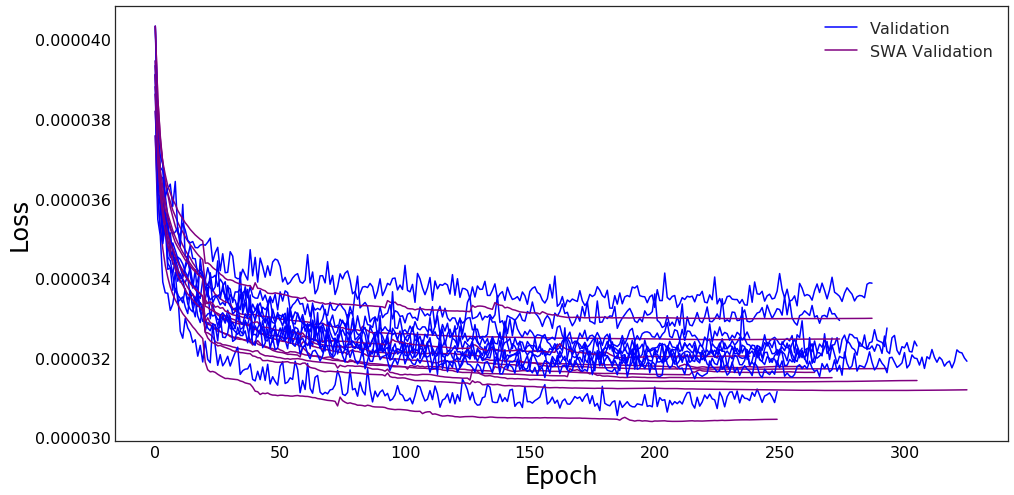

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0631 +- 0.0008
Mean AUC = 0.0984 +- 0.0005
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=1,
                                          patience=50, swaRenewal=5, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"